In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm


data = pd.read_csv('COVID data/metadata_2020-12-28_14-16.tsv', sep='\t', header=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.head()

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,Nextstrain_clade,pangolin_lineage,GISAID_clade,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted
0,Algeria/G0638_2264/2020,ncov,EPI_ISL_418241,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
1,Algeria/G0640_2265/2020,ncov,EPI_ISL_418242,?,2020-03-08,Africa,Algeria,Blida,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
2,Algeria/G0860_2262/2020,ncov,EPI_ISL_420037,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-04-04
3,Andorra/202552/2020,ncov,EPI_ISL_539496,?,2020-03-13,Europe,Andorra,Andorra,NaN,Europe,...,20A,B.1.5,O,Hospital Nostra Senyora de Meritxell,Instituto de Salud Carlos III,Iglesias-Caballero et al,https://www.gisaid.org,?,?,2020-09-18
4,Anhui/SZ005/2020,ncov,EPI_ISL_413485,?,2020-01-24,Asia,China,Anhui,Suzhou,Asia,...,19B,A,S,"Department of microbiology laboratory,Anhui Pr...","Department of microbiology laboratory,Anhui Pr...",Weiwei Li et al,https://www.gisaid.org,?,?,2020-03-05


## Selecting featured countries

Select countries with less then 10k sequences and draw hist of number of sequences (to select bounds for featured)

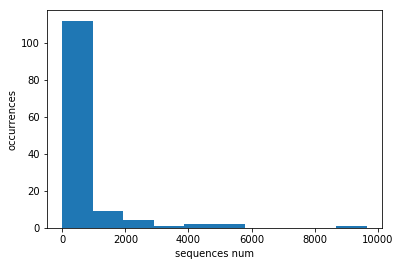

In [431]:
from collections import Counter
import matplotlib.pyplot as plt
counted = Counter(data['country'])
cnt = list(filter(lambda x: x < 10000, counted.values()))
plt.hist(list(cnt))
plt.xlabel('sequences num')
plt.ylabel('occurrences')
plt.show()

In [11]:
list(filter(lambda x: x[1] > 2000, dict(counted).items()))

[('Australia', 16540),
 ('Belgium', 2731),
 ('Netherlands', 4587),
 ('Canada', 3604),
 ('Denmark', 16790),
 ('United Kingdom', 137179),
 ('France', 2726),
 ('India', 4236),
 ('Japan', 9649),
 ('Portugal', 2203),
 ('USA', 52254),
 ('South Africa', 2801),
 ('Spain', 5612),
 ('Switzerland', 4953)]

Manually select featured: small countries with many secuences processed

In [515]:
top_countries = ['Belgium', 'Netherlands', 'Denmark', 'France', 'Japan', 'Portugal', 'Spain', 'Switzerland'] # 'South Africa'

## Prepare country-separated data

In [13]:
from collections import defaultdict
top_countries_dict = data.loc[data['country'].isin(top_countries)]['country'].to_dict()
grouped_ids = defaultdict(set)
for k, v in top_countries_dict.items():
    grouped_ids[v].add(k)

In [72]:
def create_country_file(country):
    with open('COVID data/msa_1229/msa_1229.fasta') as f:
        meta = f.readline()
        v = 0

        while meta:
            sequence = f.readline()
            if country in meta:
                with open(f"COVID data/msa_1229/countries/{country}.fasta", "a+") as cf:
                    cf.writelines([meta, sequence])
            v += 1

            meta = f.readline()

    print(v)

In [73]:
create_country_file("Belgium")

276018


In [31]:
metas = 0
v = 0
ids = set(data.loc[data['country'] == 'Belgium']['strain'].tolist())

bel_ids = set()

with open('COVID data/msa_1229/msa_1229.fasta') as f:
    meta = f.readline()
    while meta:
        sequence = f.readline()
        id_ = meta.split("|")[0][9:]
        if id_ in ids:
            bel_ids.add(id_)
        
        meta = f.readline()

In [17]:
belgium = []
metas = []
common_len = 0
with open("COVID data/Belgium.fasta", "r") as cf:
    meta = cf.readline()
    while meta:
        seq = cf.readline()
        metas.append(meta)
        belgium.append(seq)  
        meta = cf.readline()
    
print(len(belgium))

final_sequences = []
spaces = []
for seq in tqdm(list(zip(*belgium))):
    spaces.append(seq.count('-') * 1.0 / len(seq))
    if seq.count('-') * 1.0 / len(seq) > 0.1:
        continue
    final_sequences.append(seq)
print((final_sequences))

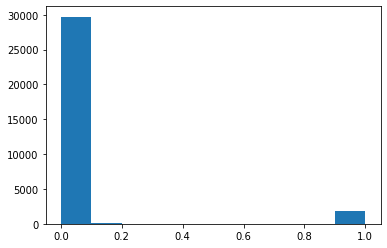

In [77]:
plt.hist(spaces)
plt.show()

## Sequences analysis

Draw hist for some subtrees and trendline to understend dynamics of key mutations distrubution

In [5]:
import io
from newick import load

def load_tree(path):
    with io.open(path, encoding='utf8') as fp:
        return load(fp)[0]

In [3]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def get_date_from_meta(meta):
    return meta.split("|")[2]

def get_id_from_meta(meta):
    return meta.split("/")[2]

def get_timestamp(date: str):
    return mdates.epoch2num(datetime.strptime(date, '%Y-%m-%d').timestamp())

def generate_bins_from_dates(start_date, end_date, timerange):
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)
    parts = list(pd.date_range(start, end, freq=timerange))
    parts_with_borders = []
    if len(parts) != 0:
        parts_with_borders = [parts[0] - pd.to_timedelta(timerange)] + parts + \
            [parts[-1] + pd.to_timedelta(timerange)]
    else: #fix only for one week timerange
        number_of_days = int(start.weekday()) + 1
        parts = [start - pd.to_timedelta(f'{number_of_days}d')]
        parts_with_borders = parts + [parts[-1] + pd.to_timedelta(timerange)]
        
    return list(map(lambda x: x.to_pydatetime().timestamp(), parts_with_borders))


def show_hist(n, bins, polynom=None, approx_polynom=None, width=1):
    fig, ax = plt.subplots(1,1)
    ax.bar(bins[:-1], n, width=width)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    if polynom is not None:
        ax.plot(bins, polynom(bins), "r--")
    plt.xlabel('date')
    plt.ylabel('%')
    if approx_polynom is not None:
        y = [np.polyval(approx_polynom, i - bins[0]) for i in bins]
        ax.plot(bins, y)
    plt.show()

def prepare_hist(leaves):
#     bounds = (get_timestamp('2019-12-24'), get_timestamp('2021-01-10'))
    dates = []
    for leaf in leaves:
        date = ''
        try:
#             dates.append(datetime.strptime(get_date_from_meta(leaf), '%Y-%m-%d'))
            #For Global
            date = data.loc[data['strain'] == leaf[1:-1], 'date'].iloc[0]
#             print(leaf)
#             print(date)
            dates.append(datetime.strptime(get_date_from_meta(date), '%Y-%m-%d'))
        except:
            try:
#                 dates.append(datetime.strptime(get_date_from_meta(date), '%Y-%m-00'))
                #For Global
                date = data.loc[data['strain'] == leaf[1:-1], 'date'].iloc[0]
#                 print(leaf)
#                 print(date)
                dates.append(datetime.strptime(get_date_from_meta(date), '%Y-%m-00'))
            except:
                pass
#     print(dates)
    if len(dates) == 0:
        print(leaves)
    bins = list(map(mdates.epoch2num, generate_bins_from_dates(min(dates), max(dates), '1w')))
    return np.histogram(list(map(lambda x: mdates.epoch2num(x.timestamp()), dates)), bins=bins)
    
def get_date_histogramm_by_subtree(leaves, totals, force_draw=False, min_k=0.02):
    ns, bins = prepare_hist(leaves)
    n1 = []
    for n, b in zip (ns, bins):
        n1.append(n / totals[b] * 100 if n != 0 else 0)
    ns = n1
# #     print(m)
# #     ns = np.vectorize(lambda x: x * m / approx_p(x))(ns)
#     n1 = []
#     for n, x in zip(ns, bins):
#         t = n + (m - approx_p(x - s))
# #         print(n, approx_p(x - s), t)
#         n1.append(t)
#     ns=n1
    
    z = np.polyfit(bins[:-1], ns, 1)
    p = np.poly1d(z)
    return (z, ns, bins, p)
#     if z[0] > min_k or force_draw:
#         print(f'Subtree size: {len(leaves)}')
#         print(f'Trendline coefficient: {z[0]}')
#         p = np.poly1d(z)
#         show_hist(ns, bins, p)
        
def prepare_approx(n, bins):
    approx = np.polyfit(bins[:-1] - bins[0], n, 10)
    return np.poly1d(approx), n.mean()

def prepare_totals(tree):
    leaves = tree.get_leaf_names()
    ns, bins = prepare_hist(leaves)
    return {b: n for n, b in zip(ns, bins)}

Subtree size: 2587
Trendline coefficient: 0.08053961542343485


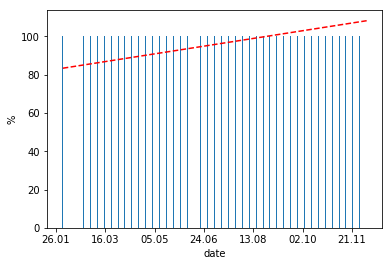

In [761]:
leaves = tree2.get_leaf_names()
# n, bins = prepare_hist(leaves)
# approx_p, m = prepare_approx(n, bins)
totals = prepare_totals(tree2)
draw_date_histogramm_by_subtree(leaves, totals, force_draw=True)

51.74
Subtree size: 2587
Trendline coefficient: 0.028486642181781287


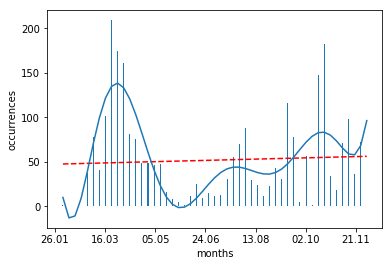

In [644]:
leaves = tree2.get_leaf_names()
n, bins = prepare_hist(leaves, 50)
approx_p, m = prepare_approx(n, bins)
draw_date_histogramm_by_subtree(leaves, approx_p, m, bins[0], force_draw=True)

In [6]:
import os

def _dig(node, stop_fn):
    if not stop_fn(node):
        res = []
        for descendant in node.descendants:
            if not descendant.is_leaf:
                res += _dig(descendant, stop_fn)
        return res
    else:
        return [node]

def analyze_subtrees(tree, size_range=(500, 1000), N=10):
    n, bins = prepare_hist(tree.get_leaf_names())
#     approx_p, m = prepare_approx(n, bins)
    totals = prepare_totals(tree)
    histogramms_with_coefficients = []
    for i in _dig(tree, lambda node: len(node.get_leaves()) < size_range[1]):
        leaves = i.get_leaf_names()
        if len(leaves) < size_range[0]:
            continue
#         (z, ns, bins, p) = get_date_histogramm_by_subtree(leaves, totals, min_k=0)
        histogramms_with_coefficients.append(get_date_histogramm_by_subtree(leaves, totals, min_k=0))
    
    top_n = sorted(histogramms_with_coefficients, key = lambda x: x[0][0], reverse = True)[:N] 
    for z, ns, bins, p in top_n:
        print(f'Trendline coefficient: {z[0]}')
        show_hist(ns, bins, p)


for country in ['Global']:#top_countries:
    print(f'\n\n{country}\n')
    tree = load_tree(os.path.join('COVID data', 'countries', country, 'tree.nwk'))
    analyze_subtrees(tree)



Global



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: min() arg is an empty sequence

In [17]:
import heapq
import operator

d = [(0.234, 34), (-0.14, 4), (-1.3, 234), (0.12, 23)]

# zip(*heapq.nlargest(2, enumerate(d), key=operator.itemgetter(1)))[0]
res = sorted(d, key = operator.itemgetter(0), reverse = True)[:5] 
res

[(0.234, 34), (0.12, 23), (-0.14, 4), (-1.3, 234)]

In [666]:
# tree = load_tree(os.path.join('COVID data', 'countries', 'Denmark', 'tree.nwk'))
analyze_subtrees(tree, size_range=(300, 1000))

In [773]:
cog_meta = pd.read_csv('COVID data/cog_metadata.csv', header=0)

In [774]:
cog_meta.head()

,sequence_name,country,adm1,pillar_2,sample_date,epi_week,lineage,lineage_support,d614g,n439k,p323l,a222v,y453f,n501y,t1001i,p681h,q27stop,del_21765_6
0,England/EXET-13F5DB/2020,UK,UK-ENG,False,2020-12-18,51,B.1.177.9,1.0,G,N,L,V,Y,N,T,P,Q,ref
1,England/EXET-136932/2020,UK,UK-ENG,False,2020-12-16,51,NaN,NaN,G,X,X,X,X,X,T,X,Q,ref
2,England/EXET-13F76C/2020,UK,UK-ENG,False,2020-12-18,51,B.1.177,1.0,G,N,L,V,Y,N,T,P,Q,ref
3,England/EXET-13F5AE/2020,UK,UK-ENG,False,2020-12-18,51,B.1.177.7,1.0,G,N,L,V,Y,N,T,P,Q,ref
4,England/EXET-1393E6/2020,UK,UK-ENG,False,2020-12-18,51,B.1.177,1.0,G,N,L,V,Y,N,T,P,Q,ref


In [39]:
data.loc[data['strain'] == tree.get_leaf_names()[0][1:-1], 'date'].iloc[0]

'2020-01-05'

In [819]:
tree.get_leaf_names()[0][1:-1]

"'Wuhan/WH04/2020'"

In [814]:
cog_meta.loc[cog_meta['sequence_name'] == "Wuhan/WH04/2020", 'sample_date']

Series([], Name: sample_date, dtype: object)

In [809]:
edges = [(1, 2), (3, 4), (4, 6)]

def get_nodes_count(edges: list):
    nodes = set()
    for n1, n2 in edges:
        nodes.add(n1)
        nodes.add(n2)
    return len(nodes)

print(get_nodes_count(edges))

5
